# Figure HMASR SCF / SD relationship
## fig04

Original notebook: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/fig_HMASR_SCF_SD.ipynb

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
plot.version

'0.6.4'

## Load data

In [5]:
res = '100km'

path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_'+res+'/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf = ds.SCA_Post.load()

# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_'+res+'.nc').load()

# Topo
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_'+res+'.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

## Plot

In [6]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

def plot_hatches_mask(ax, mask):
    mask_lats = []
    mask_lons = []

    threshold = 30
    delta = ((mask.lat[1]-mask.lat[0])/2).item(0)
    
    for lat in mask.lat.values:
        for lon in mask.lon.values:
            temp = mask.where(mask>threshold)*0+1
            if temp.sel(lat=lat, lon=lon) == 1:
                mask_lats.append(lat)
                mask_lons.append(lon)
    
    for i in range(len(mask_lats)):
        ax.add_patch(
                mpatches.Rectangle(
                    xy=[mask_lons[i]-delta, mask_lats[i]-delta], width=1, height=2*delta, transform=ccrs.PlateCarree(),
                    fill=False, zorder=10, color='black', linewidth=0, hatch='//////',
                )
            )

## Check SCF/SWE relationship

In [185]:
(swe/sd.where( (sd>swe) )*1000).where(mask < 30).groupby('time.month').mean('time').mean(('lat', 'lon'))

<xarray.DataArray (month: 12)>
array([228.31798, 237.87929, 264.8633 , 290.05188, 299.25375, 297.8882 ,
       289.63568, 273.43994, 256.29376, 230.40762, 224.48651, 227.44112],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

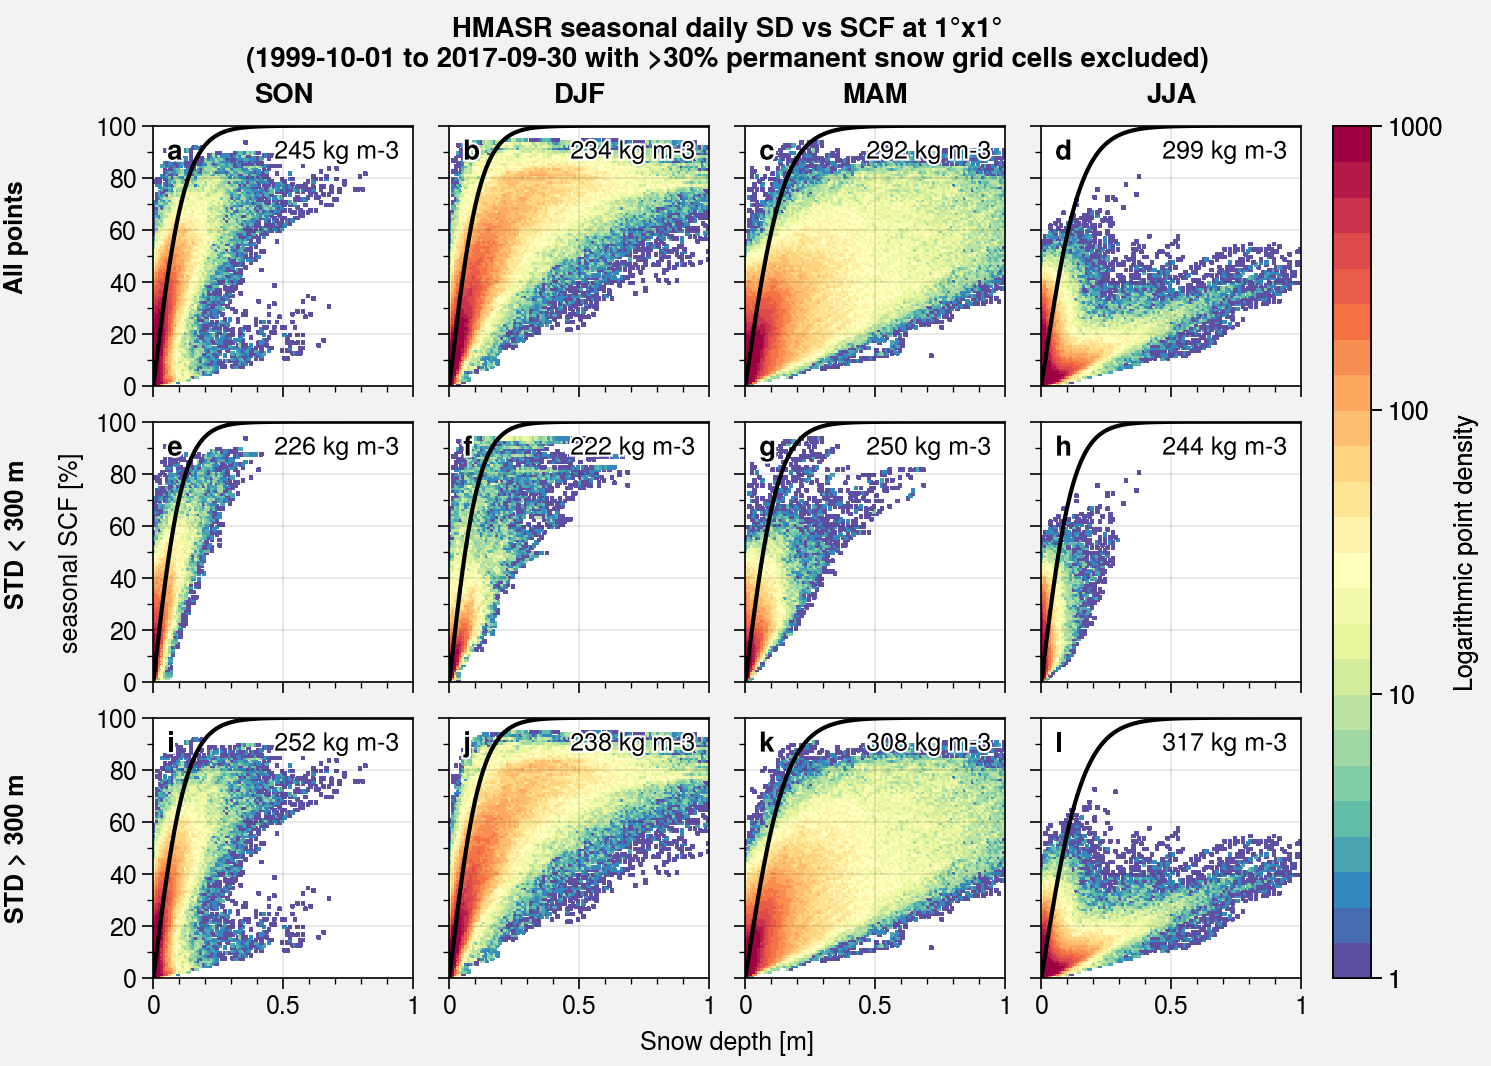

In [12]:
xylim = [[0, 1], [0, 100]]
bins = 100
cmap = 'Spectral_r'
levels = np.logspace(0, 3, 25)
cmin = 1

# months = [[10, 11], [12, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
months = [[9, 10, 11], [12, 1, 2], [3, 4, 5], [6, 7, 8]]
threshold = 300
stds = [(True), (topo_std < threshold), (topo_std > threshold)]

fig, axs = plot.subplots(ncols=len(months), nrows=len(stds), axwidth=1.3, aspect=1, space=0.18)

for j, std in enumerate(stds):
    for i, month in enumerate(months):
        ax = axs[j, i]
        density = (swe/sd*1000).where( ( (sd['time.month'] == month[0]) | (sd['time.month'] == month[1]) | (sd['time.month'] == month[2]) )  & (mask < 30) & std )
        x = sd.where( ( (scf['time.month'] == month[0]) | (scf['time.month'] == month[1]) | (scf['time.month'] == month[2]) )  & (mask < 30) & std ).values.flatten()
        y = scf.where( ( (scf['time.month'] == month[0]) | (scf['time.month'] == month[1]) | (scf['time.month'] == month[2]) )  & (mask < 30) & std ).values.flatten()*100
        
        m = ax.hist2d(x, y,bins=bins, range=xylim, cmap=cmap, cmin=cmin, levels=levels, rasterized=True)
        
        mean = density.where(density < 917).mean()
        
        ax.format(
            xlabel='Snow depth [m]',
            ylabel='seasonal SCF [%]',
            urtitle='{:.0f} kg m-3'.format(mean.values),
            rc_kw={'title.size': 9}
        )
        
        x = plot.arange(0, 1, 0.01)
        y = np.tanh(x/(2.5*0.01*(mean.values.item(0)/50)**1))*100
        ax.plot(x, y, color='k')

# for pos, label in zip(np.linspace(0.25, 0.75, 3), ['All points', 'STD < '+str(threshold)+' m', 'STD > '+str(threshold)+' m'][::-1]):
for pos, label in zip(np.linspace(0.14, 0.73, 3), ['All points', 'STD < '+str(threshold)+' m', 'STD > '+str(threshold)+' m'][::-1]):
    fig.text(0.003, pos, label, fontweight='bold', rotation='vertical')
        

fig.colorbar(m[3], ticks=np.logspace(0, 3, 4), label='Logarithmic point density', loc='r', length=1)

axs.format(
    suptitle='HMASR seasonal daily SD vs SCF at 1°x1°\n(1999-10-01 to 2017-09-30 with >30% permanent snow grid cells excluded)',
#     rowlabels=['All points', 'std < '+str(threshold)+'m', 'std > '+str(threshold)+'m'],
    collabels=['SON', 'DJF', 'MAM', 'JJA'], 
    grid=True, 
    xlocator=0.5, xminorlocator=0.1,
    ylocator=20, yminorlocator=10,
    abc=True, abcloc='ul'
)

for ext in ['jpg', 'pdf']:
    fig.save('img/fig04.'+ext)

## Other SCF params

In [10]:
# R01
def R01(swe, zstd):
    return 0.95 * np.tanh(100*swe) * np.sqrt( 1000*swe / ( 1000*swe + 0.15*zstd + 1e-6) )

scf_R01 = R01(swe, topo_std)


# NY07
def NY07(sd, z0, rho_snow, rho_new, m):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

scf_NY07_orig = NY07(sd, 0.01, swe/sd*1000, 100, 1.6)
scf_NY07_orch = NY07(sd, 0.01, swe/sd*1000, 50, 1)


# SL12
def SL12(swe, topo_std):
    
    # Initialize with first SCF
    temp = scf.copy()
    temp[1:] = np.nan 
    
    N_melt = 200 / topo_std.where(topo_std > 10, other=10) # eq. (5) in SL12 (modified)
    swe_max = ( 2. * swe[0] ) / ( 1 + np.cos( np.pi * (1 - temp[0])**(1/N_melt) ) )

    for i_time in range(swe.time.size-1):
#         print(i_time)

        delta_swe = swe[i_time+1]-swe[i_time]
                
        melt = (1 - ( 1 / np.pi * np.arccos( 2 * (swe[i_time+1] / swe_max).where(swe[i_time+1] / swe_max < 1) - 1 ) )**N_melt)

        k = 0.1 # 0.1 in SL12
        accu = (1 - ( 1 - (k*delta_swe*1e3).where(k*delta_swe*1e3 < 1, 1).where(delta_swe*0+1 == 1) ) * ( 1. - temp[i_time] ))
        total = accu.where( (delta_swe > 1e-6), melt)
        temp[i_time+1] = total.where(total > 0, 0).where(scf[0]*0+1 == 1) 
        
        swe_max = ( ( 2. * swe[i_time+1] ) / ( 1 + np.cos( np.pi * (1 - temp[i_time+1])**(1/N_melt) ) ) ).where(delta_swe > 1e-6, swe_max)
    
    return temp

scf_SL12 = SL12(swe, topo_std)


# LA22
def LA22(sd, z0, rho_snow, rho_new, m, zstd, zstd_0, m2):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m + zstd_0*zstd*(rho_snow/rho_new)**m2 ))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

scf_LA22 = LA22(sd, 0.01, swe/sd*1000, 50, 1, topo_std, 3e-6, 3)

# DNN
scf_DNN = xr.open_dataarray('results/scf_100km_ML3.nc')

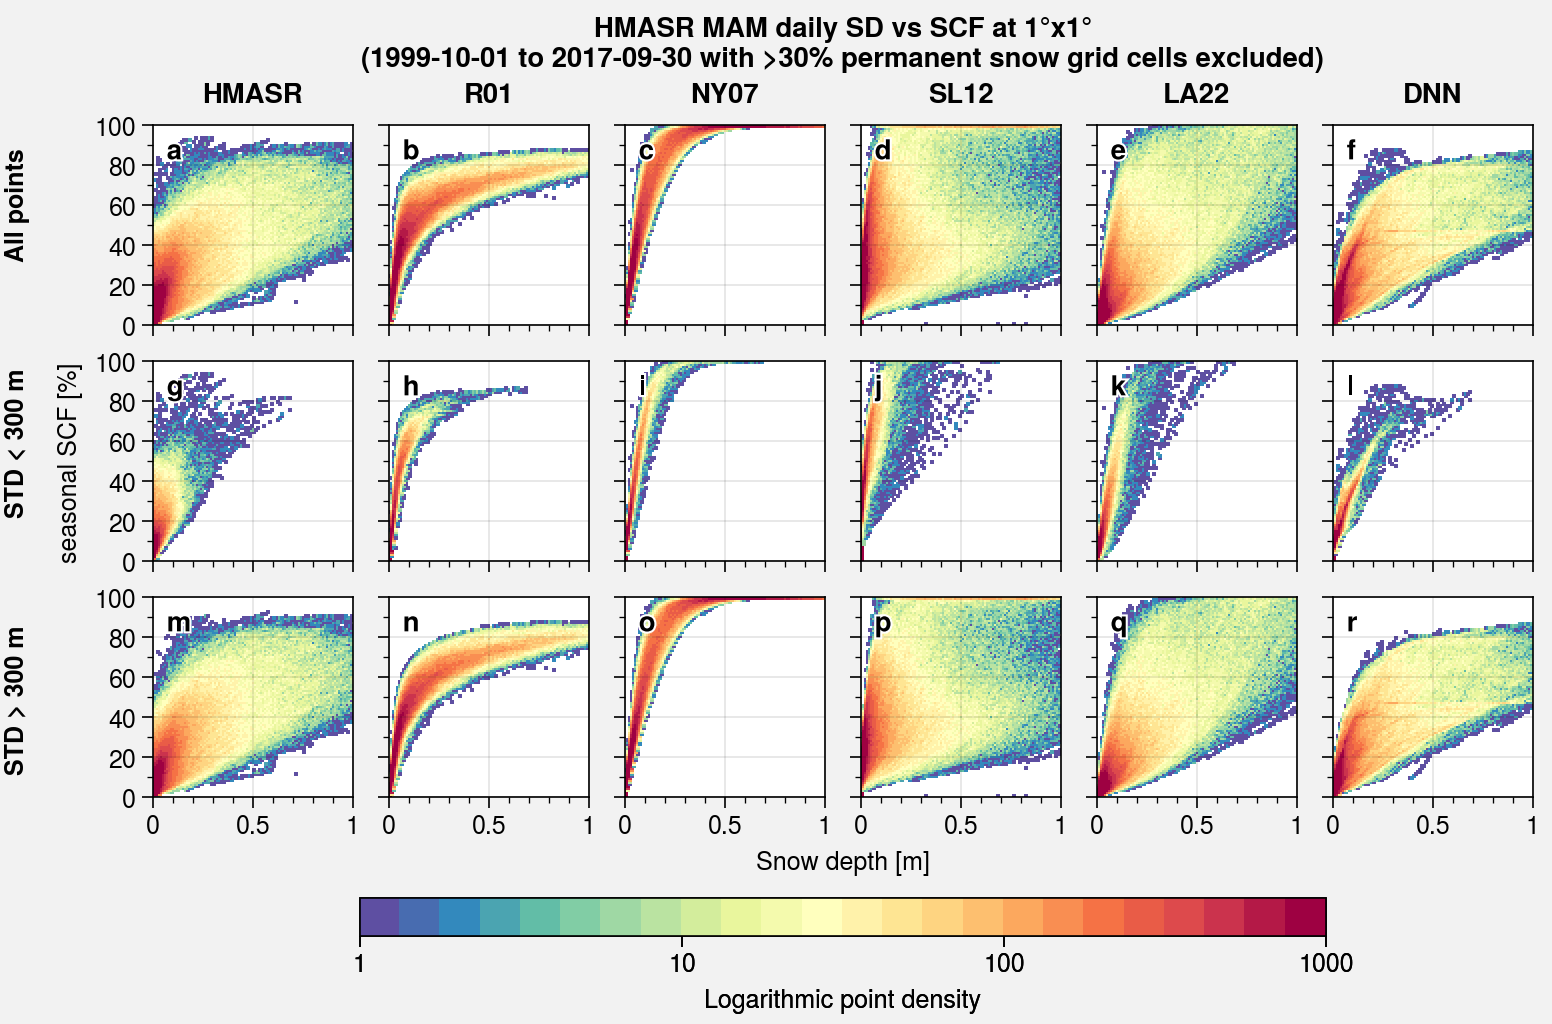

In [13]:
xylim = [[0, 1], [0, 100]]
bins = 100
cmap = 'Spectral_r'
levels = np.logspace(0, 3, 25)
cmin = 1

# months = [[10, 11], [12, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
month = [3, 4, 5]
threshold = 300
stds = [(True), (topo_std < threshold), (topo_std > threshold)]
scf_list = [scf, scf_R01, scf_NY07_orch, scf_SL12, scf_LA22, scf_DNN]
scf_labels = ['HMASR', 'R01', 'NY07', 'SL12', 'LA22', 'DNN']

fig, axs = plot.subplots(ncols=len(scf_list), nrows=len(stds), axwidth=1, aspect=1, space=0.18)

for j, std in enumerate(stds):
    for i, scf_param in enumerate(scf_list):
        ax = axs[j, i]
        density = (swe/sd*1000).where( ( (sd['time.month'] == month[0]) | (sd['time.month'] == month[1]) | (sd['time.month'] == month[2]) )  & (mask < 30) & std )
        x = sd.where( ( (scf['time.month'] == month[0]) | (scf['time.month'] == month[1]) | (scf['time.month'] == month[2]) )  & (mask < 30) & std ).values.flatten()
        y = scf_param.where( ( (scf['time.month'] == month[0]) | (scf['time.month'] == month[1]) | (scf['time.month'] == month[2]) )  & (mask < 30) & std ).values.flatten()*100
        
        m = ax.hist2d(x, y,bins=bins, range=xylim, cmap=cmap, cmin=cmin, levels=levels, rasterized=True)
        
        ax.format(
            xlabel='Snow depth [m]',
            ylabel='seasonal SCF [%]',
        )

for pos, label in zip(np.linspace(0.25, 0.75, 3), ['All points', 'STD < '+str(threshold)+' m', 'STD > '+str(threshold)+' m'][::-1]):
    fig.text(0.003, pos, label, fontweight='bold', rotation='vertical')
        
fig.colorbar(m[3], ticks=np.logspace(0, 3, 4), label='Logarithmic point density', loc='b', length=0.7)

axs.format(
    suptitle='HMASR MAM daily SD vs SCF at 1°x1°\n(1999-10-01 to 2017-09-30 with >30% permanent snow grid cells excluded)',
#     rowlabels=['All points', 'std < '+str(threshold)+'m', 'std > '+str(threshold)+'m'],
#     collabels=['SON', 'DJF', 'MAM', 'JJA'], 
    collabels=scf_labels, 
    grid=True, 
    xlocator=0.5, xminorlocator=0.1,
    ylocator=20, yminorlocator=10,
    abc=True, abcloc='ul'
)

for ext in ['jpg', 'pdf']:
    fig.save('img/fig05.'+ext)